In [3]:
import numpy as np
import wlcstat.wlc_copoly as wlc_copoly
import wlcstat.wlcstruc as wlcstruc

import sys
sys.path.append("./vertex_subroutines")
from GAMcalc import *  # Code for calculating vertex functions
import propagator  # propagator object used to store pre-calculated values
import wignerD as wd # wigner D object used to store pre-calculated values

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

pset=propagator.prop_set(nlam=10) 

# $S^{(2)}$

In [15]:
def calc_monomer_matrix(poly_mat, dens):
    # calculates the AA monomer identity cross correlation matrix
    # assumes all polymers same length/ # of monomers, equal volume fraction of each
    
    #polymat - each row is a polymer
    #dens is an array where each entry is rel vol frac of correponding polymer
    if (np.sum(dens) != 1):
        raise Exception("polymer volumer fractions do not sum to one")
    if len(np.shape(poly_mat)) == 1: #single poly
        n_p = 1
        M = len(poly_mat)
        alph1 =np.zeros(M)
        alph2 =np.zeros(M)
        sig1 = 1*(poly_mat == alph1)
        sig2 = 1*(poly_mat == alph2)
        M2_AA = np.outer(sig1, sig2)
        return M2_AA
    
    n_p = poly_mat.shape[0]
    M = poly_mat.shape[1]
    alph1 =np.zeros((n_p, M))
    alph2 =np.zeros((n_p, M))
    
    #extend dens into n_pxM matrix
    poly_weights = (np.ones((n_p, M)).T * dens).T
    
    #multiply sigams by density of each polymer
    sigma1 = 1*((poly_mat == alph1))#.sum(axis = 0) #sigma. could multiply each
    sigma2 = 1*((poly_mat == alph2))#.sum(axis = 0)

    #need to do each row outer product with corresponding row, get n_p MxM matrices, then sum the results
    prods = np.einsum('bi,bo->bio', sigma1*poly_weights, sigma2) # performing row wise cross product (each poly contribution)
    M2_AA = np.sum(prods, axis = 0)#           ^^^^ averaging each contribution
    return M2_AA

In [14]:
def calc_sf2(poly_mat, dens, N_m=1, b=1, k_vec = np.logspace(-2, 2, 50)):
    #calculates all variations of the S(2) AA AB BB for a range of k
    M2_AA = calc_monomer_matrix(poly_mat, dens)
    M = np.shape(M2_AA)[0]
    nk = len(k_vec)

    one = np.ones((M,M))
    grid = np.indices((M, M))
    S2_AA_arr = np.zeros(nk)
    S2_AB_arr_fast = np.zeros(nk)
    S2_BB_arr_fast = np.zeros(nk)


    H_AA = np.diag(M2_AA)
    H_AA_mat = (H_AA * one).T
    for i, k in enumerate(k_vec):
        C = np.zeros((M, M))
        x_m = (1/6) * N_m * b**2 * k**2

        #j1 = j2
        debye = (2/(x_m**2)) * (x_m + np.exp(-x_m) - 1) * (1/M**2)

        np.fill_diagonal(C, np.diag(one * debye))

        integral = (1/(x_m**2)) * (np.exp(x_m) + np.exp(-x_m) - 2) #for off-diagonal terms

        #j1 > j2
        j1minusj2_mat = grid[0] - grid[1]
        C += np.tril(one * np.exp(-x_m*(j1minusj2_mat)) * integral * (1/M**2), k = -1)

        #j2 > j1
        j2minusj1_mat = -1 * j1minusj2_mat
        C += np.triu(one * np.exp(-x_m*(j2minusj1_mat)) * integral * (1/M**2), k = 1) 
        
        
        S2_AA_arr[i] = np.sum(C * M2_AA)


        C_AB = H_AA_mat * C
        S2_AB_arr_fast[i] = np.sum(C_AB) - S2_AA_arr[i]
        S2_BB_arr_fast[i] = np.sum(C) + S2_AA_arr[i] - 2*np.sum(C_AB)
    return (S2_AA_arr, S2_AB_arr_fast, S2_BB_arr_fast)

In [18]:
def calc_sf2_inv(poly_mat, dens, N_m=1, b=1, k_vec = np.logspace(-2, 2, 50)):
    (S2_AA_arr, S2_AB_arr, S2_BB_arr) = calc_sf2(poly_mat, dens, N_m, b, k_vec)
    det = S2_AA_arr * S2_BB_arr - S2_AB_arr**2
    S2_AA_inv = S2_BB_arr * (1/det)
    S2_AB_inv = -S2_AB_arr * (1/det)
    S2_BB_inv = S2_AA_arr * (1/det)
    return (S2_AA_inv, S2_AB_inv, S2_BB_inv)

In [19]:
def find_kstar(poly_mat, dens, N_m=1, b=1, k_vec = np.logspace(-2, 2, 50)):
    (S2_AA_inv, S2_AB_inv, S2_BB_inv) = calc_sf2_inv(poly_mat, dens, N_m, b, k_vec)
    G2 = 0.5*(S2_AA_inv - 2* S2_AB_inv + S2_BB_inv) # chi = 0

    # eigvalues,eigvectors = np.linalg.eigh(G2)
    eigvalues_lst = G2
    min_eig = np.min(eigvalues_lst[~np.isnan(eigvalues_lst)])

    k_star = k_vec[np.where(eigvalues_lst==min_eig)]#[0]][0] 
    return k_star

### Identical homopolymers

In [4]:
%%time
poly_mat = np.array([[0,0,0],[0,0,0]]) # each row is a polymer
dens = np.array([0.5, 0.5])
N_m = 1
b = 1

M = poly_mat.shape[1]
k_vec = np.logspace(-2, 2, 50)

(S2_AA_arr, S2_AB_arr_fast, S2_BB_arr_fast) = calc_sf2(poly_mat, dens, N_m, b, k_vec)

Wall time: 22.1 ms


<ipython-input-3-6279301b2a2a>:29: RuntimeWarning: overflow encountered in multiply
  C += np.tril(one * np.exp(-x_m*(j1minusj2_mat)) * integral * (1/M**2), k = -1)
<ipython-input-3-6279301b2a2a>:33: RuntimeWarning: overflow encountered in multiply
  C += np.triu(one * np.exp(-x_m*(j2minusj1_mat)) * integral * (1/M**2), k = 1)
<ipython-input-3-6279301b2a2a>:29: RuntimeWarning: overflow encountered in exp
  C += np.tril(one * np.exp(-x_m*(j1minusj2_mat)) * integral * (1/M**2), k = -1)
<ipython-input-3-6279301b2a2a>:33: RuntimeWarning: overflow encountered in exp
  C += np.triu(one * np.exp(-x_m*(j2minusj1_mat)) * integral * (1/M**2), k = 1)
<ipython-input-3-6279301b2a2a>:25: RuntimeWarning: overflow encountered in exp
  integral = (1/(x_m**2)) * (np.exp(x_m) + np.exp(-x_m) - 2) #for off-diagonal terms
<ipython-input-3-6279301b2a2a>:29: RuntimeWarning: invalid value encountered in multiply
  C += np.tril(one * np.exp(-x_m*(j1minusj2_mat)) * integral * (1/M**2), k = -1)
<ipython-input-3-6

In [5]:
N = N_m * M

x = (1/6) * N * b**2 * (k_vec**2)
debye_arr = (2/(x**2)) * (x + np.exp(-x) - 1) #* (1/N**2)

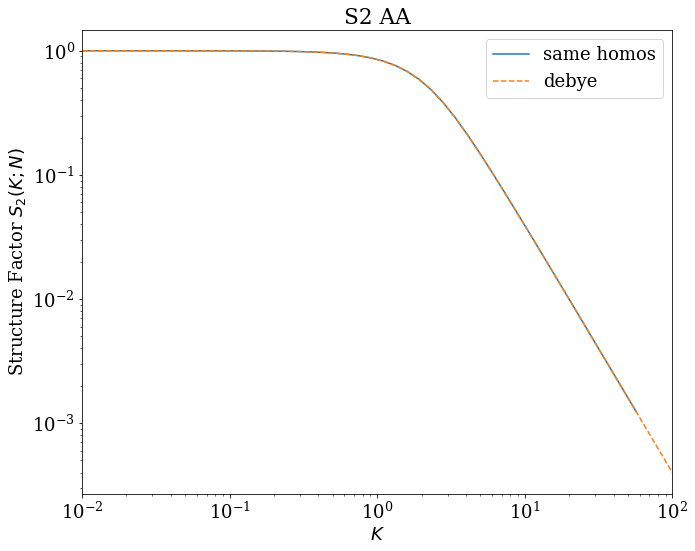

In [6]:
plt.figure(figsize=(10,8))
font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

plt.plot(k_vec, S2_AA_arr, label = "same homos")
# plt.plot(k_vec, s2AA_stat, label = "wlcstat N = " + str(N))
plt.plot(k_vec, debye_arr, label = "debye", linestyle = "--")

plt.xscale('log')
plt.yscale('log')

plt.title("S2 AA")
plt.xlabel(r'$K$')
plt.ylabel(r'Structure Factor $S_{2}(K;N)$')
plt.xlim((1e-2, 1e2))
plt.tight_layout()
plt.legend()
plt.show()

### Monodisperse diblock 

In [20]:
%%time
poly_mat = np.array([[0,1],[0,1]]) # each row is a polymer
dens = np.array([0.5, 0.5])
N_m = 1
b = 1

M = poly_mat.shape[1]
k_vec = np.logspace(-2, 2, 50)

(S2_AA_arr, S2_AB_arr_fast, S2_BB_arr_fast) = calc_sf2(poly_mat, dens, N_m, b, k_vec)

Wall time: 31.3 ms


<ipython-input-14-6279301b2a2a>:29: RuntimeWarning: overflow encountered in multiply
  C += np.tril(one * np.exp(-x_m*(j1minusj2_mat)) * integral * (1/M**2), k = -1)
<ipython-input-14-6279301b2a2a>:33: RuntimeWarning: overflow encountered in multiply
  C += np.triu(one * np.exp(-x_m*(j2minusj1_mat)) * integral * (1/M**2), k = 1)
<ipython-input-14-6279301b2a2a>:25: RuntimeWarning: overflow encountered in exp
  integral = (1/(x_m**2)) * (np.exp(x_m) + np.exp(-x_m) - 2) #for off-diagonal terms
<ipython-input-14-6279301b2a2a>:29: RuntimeWarning: overflow encountered in exp
  C += np.tril(one * np.exp(-x_m*(j1minusj2_mat)) * integral * (1/M**2), k = -1)
<ipython-input-14-6279301b2a2a>:29: RuntimeWarning: invalid value encountered in multiply
  C += np.tril(one * np.exp(-x_m*(j1minusj2_mat)) * integral * (1/M**2), k = -1)
<ipython-input-14-6279301b2a2a>:33: RuntimeWarning: overflow encountered in exp
  C += np.triu(one * np.exp(-x_m*(j2minusj1_mat)) * integral * (1/M**2), k = 1)
<ipython-inp

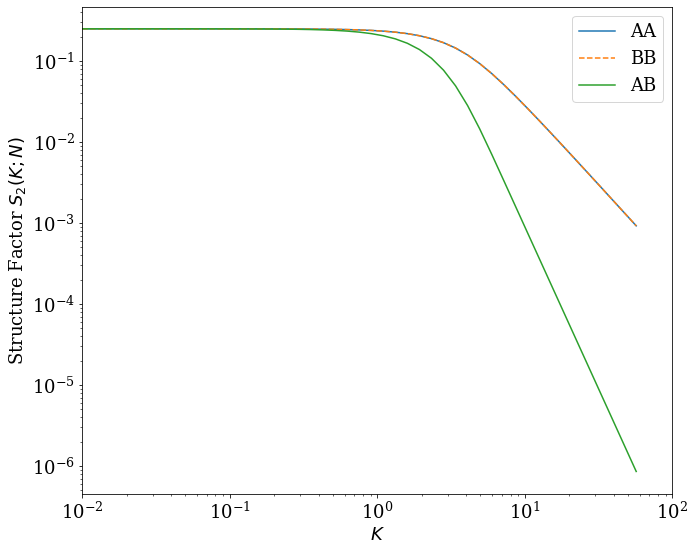

In [21]:
plt.figure(figsize=(10,8))
font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

plt.plot(k_vec, S2_AA_arr, label = "AA")
plt.plot(k_vec, S2_BB_arr_fast, label = "BB", linestyle = "--")
plt.plot(k_vec, S2_AB_arr_fast, label = "AB")


# plt.plot(k_vec, S2_BB_arr, label = "slow", linestyle = "--")
# plt.plot(k_vec, s2AA_stat, label = "wlcstat N = " + str(N))
# plt.plot(k_vec, debye_arr, label = "debye homo N = " + str(N), linestyle = "--")

plt.xscale('log')
plt.yscale('log')

# plt.title("S2")
plt.xlabel(r'$K$')
plt.ylabel(r'Structure Factor $S_{2}(K;N)$')
plt.xlim((1e-2, 1e2))
plt.tight_layout()
plt.legend()
plt.show()

#### stability analysis

In [22]:
find_kstar(poly_mat, dens, N_m=1, b=1, k_vec = np.logspace(-2, 2, 50))

<ipython-input-14-6279301b2a2a>:29: RuntimeWarning: overflow encountered in multiply
  C += np.tril(one * np.exp(-x_m*(j1minusj2_mat)) * integral * (1/M**2), k = -1)
<ipython-input-14-6279301b2a2a>:33: RuntimeWarning: overflow encountered in multiply
  C += np.triu(one * np.exp(-x_m*(j2minusj1_mat)) * integral * (1/M**2), k = 1)
<ipython-input-14-6279301b2a2a>:25: RuntimeWarning: overflow encountered in exp
  integral = (1/(x_m**2)) * (np.exp(x_m) + np.exp(-x_m) - 2) #for off-diagonal terms
<ipython-input-14-6279301b2a2a>:29: RuntimeWarning: overflow encountered in exp
  C += np.tril(one * np.exp(-x_m*(j1minusj2_mat)) * integral * (1/M**2), k = -1)
<ipython-input-14-6279301b2a2a>:29: RuntimeWarning: invalid value encountered in multiply
  C += np.tril(one * np.exp(-x_m*(j1minusj2_mat)) * integral * (1/M**2), k = -1)
<ipython-input-14-6279301b2a2a>:33: RuntimeWarning: overflow encountered in exp
  C += np.triu(one * np.exp(-x_m*(j2minusj1_mat)) * integral * (1/M**2), k = 1)
<ipython-inp

array([3.39322177])

In [9]:
# diblocks
det = S2_AA_arr * S2_BB_arr_fast - S2_AB_arr_fast**2
S2_AA_inv = S2_BB_arr_fast * (1/det)
S2_AB_inv = -S2_AB_arr_fast * (1/det)
S2_BB_inv = S2_AA_arr * (1/det)

# G2 = (0.5*np.array([[S2_AA_inv, S2_AB_inv], [S2_AB_inv, S2_BB_inv]])).T.reshape(len(k_vec), 2, 2) 

G2 = 0.5*(S2_AA_inv - 2* S2_AB_inv + S2_BB_inv) # chi = 0

# eigvalues,eigvectors = np.linalg.eigh(G2)
eigvalues_lst = G2
min_eig = np.min(eigvalues_lst[~np.isnan(eigvalues_lst)])

k_star = k_vec[np.where(eigvalues_lst==min_eig)]#[0]][0] 

In [10]:
k_star

array([3.39322177])

### Homopolymer mix

#### stability analysis

In [23]:
%%time
poly_mat = np.array([[1,1],[0,0]]) # each row is a polymer
dens = np.array([0.5, 0.5])
N_m = 1
b = 1

M = poly_mat.shape[1]
k_vec = np.logspace(-2, 2, 50)

(S2_AA_arr, S2_AB_arr_fast, S2_BB_arr_fast) = calc_sf2(poly_mat, dens, N_m, b, k_vec)

det = S2_AA_arr * S2_BB_arr_fast - S2_AB_arr_fast**2
S2_AA_inv = S2_BB_arr_fast * (1/det)
S2_AB_inv = -S2_AB_arr_fast * (1/det)
S2_BB_inv = S2_AA_arr * (1/det)

# G2 = (0.5*np.array([[S2_AA_inv, S2_AB_inv], [S2_AB_inv, S2_BB_inv]])).T.reshape(len(k_vec), 2, 2) 

G2 = 0.5*(S2_AA_inv - 2* S2_AB_inv + S2_BB_inv) # chi = 0

# eigvalues,eigvectors = np.linalg.eigh(G2)
eigvalues_lst = G2
min_eig = np.min(eigvalues_lst[~np.isnan(eigvalues_lst)])

k_star = k_vec[np.where(eigvalues_lst==min_eig)]#[0]][0] 

Wall time: 6.51 ms


<ipython-input-14-6279301b2a2a>:29: RuntimeWarning: overflow encountered in multiply
  C += np.tril(one * np.exp(-x_m*(j1minusj2_mat)) * integral * (1/M**2), k = -1)
<ipython-input-14-6279301b2a2a>:33: RuntimeWarning: overflow encountered in multiply
  C += np.triu(one * np.exp(-x_m*(j2minusj1_mat)) * integral * (1/M**2), k = 1)
<ipython-input-14-6279301b2a2a>:25: RuntimeWarning: overflow encountered in exp
  integral = (1/(x_m**2)) * (np.exp(x_m) + np.exp(-x_m) - 2) #for off-diagonal terms
<ipython-input-14-6279301b2a2a>:29: RuntimeWarning: overflow encountered in exp
  C += np.tril(one * np.exp(-x_m*(j1minusj2_mat)) * integral * (1/M**2), k = -1)
<ipython-input-14-6279301b2a2a>:29: RuntimeWarning: invalid value encountered in multiply
  C += np.tril(one * np.exp(-x_m*(j1minusj2_mat)) * integral * (1/M**2), k = -1)
<ipython-input-14-6279301b2a2a>:33: RuntimeWarning: overflow encountered in exp
  C += np.triu(one * np.exp(-x_m*(j2minusj1_mat)) * integral * (1/M**2), k = 1)
<ipython-inp

In [24]:
find_kstar(poly_mat, dens, N_m=1, b=1, k_vec = np.logspace(-2, 2, 50))

<ipython-input-14-6279301b2a2a>:29: RuntimeWarning: overflow encountered in multiply
  C += np.tril(one * np.exp(-x_m*(j1minusj2_mat)) * integral * (1/M**2), k = -1)
<ipython-input-14-6279301b2a2a>:33: RuntimeWarning: overflow encountered in multiply
  C += np.triu(one * np.exp(-x_m*(j2minusj1_mat)) * integral * (1/M**2), k = 1)
<ipython-input-14-6279301b2a2a>:25: RuntimeWarning: overflow encountered in exp
  integral = (1/(x_m**2)) * (np.exp(x_m) + np.exp(-x_m) - 2) #for off-diagonal terms
<ipython-input-14-6279301b2a2a>:29: RuntimeWarning: overflow encountered in exp
  C += np.tril(one * np.exp(-x_m*(j1minusj2_mat)) * integral * (1/M**2), k = -1)
<ipython-input-14-6279301b2a2a>:29: RuntimeWarning: invalid value encountered in multiply
  C += np.tril(one * np.exp(-x_m*(j1minusj2_mat)) * integral * (1/M**2), k = -1)
<ipython-input-14-6279301b2a2a>:33: RuntimeWarning: overflow encountered in exp
  C += np.triu(one * np.exp(-x_m*(j2minusj1_mat)) * integral * (1/M**2), k = 1)
<ipython-inp

array([0.01])

In [25]:
k_star

array([0.01])

In [ ]:
#TODO:
# -find full spinodal of monodisperse diblock, compare to vertex/Leibler (verification)
# -vectorize wrt k? using curvature to determine mirco vs macro phase sep?
# -S3, S4

# $S^{(3)}$

In [22]:
def calc_monomer_matrix_3(poly_mat, dens):
    # calculates the AAA monomer identity cross correlation matrix
    # assumes all polymers same length/ # of monomers, equal volume fraction of each
    
    # polymat - each row is a polymer
    # dens is an array where each entry is rel vol frac of correponding polymer
    if (np.sum(dens) != 1):
        raise Exception("polymer volumer fractions do not sum to one")
    if len(np.shape(poly_mat)) == 1: # single poly
        n_p = 1
        M = len(poly_mat)
        alph1 =np.zeros(M)
        alph2 =np.zeros(M)
        alph3 =np.zeros(M)
        sig1 = 1*(poly_mat == alph1)
        sig2 = 1*(poly_mat == alph2)
        sig3 = 1*(poly_mat == alph3)
#         M2_AA = np.outer(sig1, sig2)
        M3_AA = np.einsum('i,j,k',sig1,sig2,sig3)
        return M3_AA
    
    n_p = poly_mat.shape[0]
    M = poly_mat.shape[1]
    alph1 =np.zeros((n_p, M))
    alph2 =np.zeros((n_p, M))
    alph3 =np.zeros((n_p, M))

    
    #extend dens into n_pxM matrix
    poly_weights = (np.ones((n_p, M)).T * dens).T
    
    #multiply sigams by density of each polymer
    sigma1 = 1*((poly_mat == alph1))#.sum(axis = 0) #sigma. could multiply each
    sigma2 = 1*((poly_mat == alph2))#.sum(axis = 0)
    sigma3 = 1*((poly_mat == alph3))
    
    #need to do each row outer product with corresponding row, get n_p MxMxM matrices, then sum the results
    prods = np.einsum('bi,bo,bn->bion', sigma1*poly_weights, sigma2, sigma3) # performing row wise cross product (each poly contribution)
    M3_AA = np.sum(prods, axis = 0)#           ^^^^ averaging each contribution
    return M3_AA

In [116]:
C = np.zeros((2, 2, 2))
grid = np.indices((2,2,2))
j1 = grid[0]
j2 = grid[1]
j3 = grid[2]

indxs = (j1 > j2) * (j2 == j3)
intgrl = 1
cons = 22

rplcr22 = indxs * (intgrl * cons) # 0 at indices where value shouldnt be replaced, correct value at valid indices
C[np.where(rplcr22 != 0)] = rplcr22[np.where(rplcr22 != 0)] 


# j1 < (j2 = j3)

indxs = (j1 < j2) * (j2 == j3)

intgrl = 1
cons = 33

rplcr33 = indxs * (intgrl * cons)
C[np.where(rplcr33 != 0)] = rplcr33[np.where(rplcr33 != 0)]        


# j2 > (j1 = j3)

indxs = (j2 > j1) * (j1 == j3)

intgrl = 1
cons = 44

rplcr44 = indxs * (intgrl * cons)
C[np.where(rplcr44 != 0)] = rplcr44[np.where(rplcr44 != 0)]  


# j2 < (j1 = j3)

indxs = (j2 < j1) * (j1 == j3)

intgrl = 1
cons = 55

rplcr55 = indxs * (intgrl * cons)
C[np.where(rplcr55 != 0)] = rplcr55[np.where(rplcr55 != 0)] 

indxs = (j3 < j1) * (j1 == j2)

intgrl = 1
cons = 666

rplcr666 = indxs * (intgrl * cons)
C[np.where(rplcr666 != 0)] = rplcr666[np.where(rplcr666 != 0)] 

In [166]:
def calc_sf3(poly_mat, dens, N_m=1, b=1, k_vec = np.logspace(-2, 2, 50), k_vec_2 = np.logspace(-2, 2, 50)):
    #calculates all variations of the S(3) AAA AAB ABB BBB for a range of k
    M3_AAA = calc_monomer_matrix_3(poly_mat, dens)
    M = np.shape(M3_AAA)[0]
    nk = len(k_vec)

    one = np.ones((M,M,M))
    grid = np.indices((M,M,M))
    j1 = grid[0]
    j2 = grid[1]
    j3 = grid[2]
    
    S3_AAA_arr = np.zeros(nk)
    
    S2_AB_arr_fast = np.zeros(nk)
    S2_BB_arr_fast = np.zeros(nk)


#     H_AA = np.diag(M2_AA)
#     H_AA_mat = (H_AA * one).T
    
    for i, k_1 in enumerate(k_vec):
        for k_2 in k_vec_2:
            C = np.zeros((M, M, M))
            xm_1 = -(1/6) * N_m * b**2 * k_1**2  #NOTE THIS XM is NEGATIVE
            xm_2 = -(1/6) * N_m * b**2 * k_2**2 

            # j1 = j2 = j3

                # s1 > s2 > s3             = s2 > s1 > s3 = s3 > s1 > s2 = s3 > s2 > s1 (*4)
            diag1 = 4 * (1/(xm_1**2 * xm_2 * (xm_1 + xm_2)**2)) * \
            np.exp(xm_1 + xm_2)*xm_1**2 - np.exp(xm_1) * (xm_1+xm_2)**2 + \
            xm_2*(xm_1**2 + xm_2 + xm_1 * (2 + xm_2))
            
                # s1 > s3 > s2 = s2 > s3 > s1
            fr1 = (-1 + np.exp(-xm_1))* (xm_2 / xm_1)
            fr2 = (xm_1 * (1 - np.exp(xm_2) + xm_2)) / xm_2
            diag2 = 2 * -1 * (1/(xm_1 * xm_2 *(xm_1 + xm_2))) \
            * (xm_2 + fr1 + fr2)
            
            np.fill_diagonal(C, np.diagonal(one * (diag1 + diag2)))



            # j1 > (j2 = j3)           ?=  j2 > (j1 = j3) = j1 < (j2 = j3) = j2

            indxs = (j1 > j2) * (j2 == j3)

            intgrl = (1/(xm_1**2 * (xm_1 - xm_2) * xm_2)) *(1 - np.exp(-xm_1)) * \
            (xm_2 * (np.exp(xm_1) - 1) - xm_1 * (np.exp(xm_2) - 1))
            cons = 2 * np.exp(xm_1*(j1-j3)) 

            rplcr = indxs * (intgrl * cons) # 0 at indices where value shouldnt be replaced, correct value at valid indices
            C[np.where(rplcr != 0)] = rplcr[np.where(rplcr != 0)] 



            # j2 > (j1 = j3)

            indxs = (j2 > j1) * (j1 == j3)

    #         intgrl =    same as above!
            cons = 2 * np.exp(xm_1*(j2-j3))

            rplcr = indxs * (intgrl * cons)
            C[np.where(rplcr != 0)] = rplcr[np.where(rplcr != 0)]  



            # j1 < (j2 = j3)

            indxs = (j1 < j2) * (j2 == j3)

            intgrl = (1/(xm_1**2 * (xm_1 + xm_2) * xm_2)) *(1 - np.exp(-xm_1))\
            * (np.exp(xm_1) *(np.exp(xm_2) - 1)*xm_1 - (np.exp(xm_1) - 1)*xm_2) \

            cons = 2 * np.exp(xm_1*(j3-j1))

            rplcr = indxs * (intgrl * cons)
            C[np.where(rplcr != 0)] = rplcr[np.where(rplcr != 0)]        



            # j2 < (j1 = j3)

            indxs = (j2 < j1) * (j1 == j3)

    #         intgrl =    same as above
            cons =  2 * np.exp(xm_1*(j3-j2))

            rplcr = indxs * (intgrl * cons)
            C[np.where(rplcr != 0)] = rplcr[np.where(rplcr != 0)] 


            # j3 > (j1 = j2)

            indxs = (j3 > j1) * (j1 == j2)

            intgrl = -2 * (np.sinh(xm_1) + np.sinh(xm_2) - np.sinh(xm_1 + xm_2)) \
            * (1 / (xm_1*xm_2 * (xm_1 + xm_2)))
            cons = np.exp(xm_1 *(j3 - j1) + xm_2 * (j3 - j1))

            rplcr = indxs * (intgrl * cons)
            C[np.where(rplcr != 0)] = rplcr[np.where(rplcr != 0)] 


            # j3 < (j1 = j2)

            indxs = (j3 < j1) * (j1 == j2)

    #         intgrl = same as above
            cons = np.exp(xm_1 *(j1 - j3) + xm_2 * (j1 - j3))

            rplcr = indxs * (intgrl * cons)
            C[np.where(rplcr != 0)] = rplcr[np.where(rplcr != 0)] 



            # j1 > j2 > j3

            indxs = (j1 > j2) * (j2 > j3)

    #         intgrl = same as above
            cons = np.exp(xm_1 *(j1 - j3) + xm_2 * (j2 - j3))

            rplcr = indxs * (intgrl * cons)
            C[np.where(rplcr != 0)] = rplcr[np.where(rplcr != 0)] 

            # j2 > j1 > j3

            indxs = (j2 > j1) * (j1 > j3)

    #         intgrl = same as above
    #         cons = same as above

            rplcr = indxs * (intgrl * cons)
            C[np.where(rplcr != 0)] = rplcr[np.where(rplcr != 0)] 


            #j3 > j2 > j1

            indxs = (j3 > j2) * (j2 > j1)

    #         intgrl = same as above
            cons = np.exp(xm_1 *(j3 - j1) + xm_2 * (j3 - j2))

            rplcr = indxs * (intgrl * cons)
            C[np.where(rplcr != 0)] = rplcr[np.where(rplcr != 0)]         

            #j3 > j1 > j2    

            indxs = (j3 > j1) * (j1 > j2)

    #         intgrl = same as above
    #         cons =  same as above

            rplcr = indxs * (intgrl * cons)
            C[np.where(rplcr != 0)] = rplcr[np.where(rplcr != 0)]           

            #j1 > j3 > j2

            indxs = (j1 > j3) * (j3 > j2)

            intgrl = (1/(xm_1 * xm_2 * (xm_1 - xm_2))) * \
            -2 * (-np.sinh(xm_1) + np.sinh(xm_1 - xm_2) + np.sinh(xm_2))
            cons = np.exp(xm_1 *(j1 - j3) + xm_2 * (j3 - j2))

            rplcr = indxs * (intgrl * cons)
            C[np.where(rplcr != 0)] = rplcr[np.where(rplcr != 0)]        

            #j2 > j3 > j1

            indxs = (j2 > j3) * (j3 > j1)

    #         intgrl = same as above
            cons = np.exp(xm_1 *(j3 - j1) + xm_2 * (j2 - j3))

            rplcr = indxs * (intgrl * cons)
            C[np.where(rplcr != 0)] = rplcr[np.where(rplcr != 0)]  



            S3_AAA_arr[i] = np.sum((1/M**3) * C * M3_AAA)


        return (S3_AAA_arr)#, S2_AB_arr_fast, S2_BB_arr_fast)

In [167]:
k0 = 1e-2
kf = 1e2
nk = 10
k_vec = np.logspace(np.log10(k0), np.log10(kf), nk)#*rg2**0.5


k1_vec = np.zeros((nk, 3))
k2_vec = np.zeros((nk, 3))

k1_vec[:, 0] += np.logspace(np.log10(k0), np.log10(kf), nk)#*rg2**0.5
theta = 2*np.pi/3 #2* np.pi * 1 / 3

frac = 1
k2_vec[:, 0] += frac * np.cos(theta) * np.logspace(np.log10(k0), np.log10(kf), nk)
k2_vec[:, 1] += frac * np.sin(theta) * np.logspace(np.log10(k0), np.log10(kf), nk)
k3_vec = - k1_vec - k2_vec

k1_val = np.sqrt(np.sum(k1_vec ** 2,axis = 1))
k2_val = np.sqrt(np.sum(k2_vec ** 2,axis = 1))
k3_val = np.sqrt(np.sum(k3_vec ** 2,axis = 1))


In [168]:
poly_mat = np.array([0,0]) # each row is a polymer
dens = np.array([1])
N_m = 1.
b = 1.

In [169]:
calc_sf3(poly_mat, dens, N_m, b, k1_val, k2_val)

<ipython-input-166-1ef838540256>:99: RuntimeWarning: overflow encountered in sinh
  intgrl = -2 * (np.sinh(xm_1) + np.sinh(xm_2) - np.sinh(xm_1 + xm_2)) \
<ipython-input-166-1ef838540256>:99: RuntimeWarning: invalid value encountered in double_scalars
  intgrl = -2 * (np.sinh(xm_1) + np.sinh(xm_2) - np.sinh(xm_1 + xm_2)) \
<ipython-input-166-1ef838540256>:101: RuntimeWarning: overflow encountered in exp
  cons = np.exp(xm_1 *(j3 - j1) + xm_2 * (j3 - j1))
<ipython-input-166-1ef838540256>:112: RuntimeWarning: overflow encountered in exp
  cons = np.exp(xm_1 *(j1 - j3) + xm_2 * (j1 - j3))
<ipython-input-166-1ef838540256>:124: RuntimeWarning: overflow encountered in exp
  cons = np.exp(xm_1 *(j1 - j3) + xm_2 * (j2 - j3))
<ipython-input-166-1ef838540256>:145: RuntimeWarning: overflow encountered in exp
  cons = np.exp(xm_1 *(j3 - j1) + xm_2 * (j3 - j2))
<ipython-input-166-1ef838540256>:165: RuntimeWarning: overflow encountered in sinh
  -2 * (-np.sinh(xm_1) + np.sinh(xm_1 - xm_2) + np.sinh(

array([nan,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [ ]:
#how to simplify function?

# how does relative k angle even mattter if k1**2 and k2**2 ?? 
    # am i doing the integrals wrong??

# Old code

In [ ]:
def calc_monomer_matrixOLD(poly_mat):
    # calculates the AA monomer identity cross correlation matrix
    # assumes all polymers same length/ # of monomers, equal volume fraction of each
    
    if len(np.shape(poly_mat)) == 1: #single poly
        n_p = 1
        M = len(poly)
        alph1 =np.zeros(M)
        alph2 =np.zeros(M)
        sig1 = 1*(poly == alph1)
        sig2 = 1*(poly == alph2)
        M2_AA = np.outer(sig1, sig2)
        return M2_AA
    
    n_p = poly_mat.shape[0]
    M = poly_mat.shape[1]
    alph1 =np.zeros((n_p, M))
    alph2 =np.zeros((n_p, M))
    
    sigma1 = 1*((poly_mat == alph1))#.sum(axis = 0) #sigma. could multiply each
    sigma2 = 1*((poly_mat == alph2))#.sum(axis = 0)

    #need to do each row outer product with corresponding row, get n_p MxM matrices, then sum the results
    prods = np.einsum('bi,bo->bio', sigma1, sigma2) # performing row wise cross product (each poly contribution)
    M2_AA = np.sum(prods, axis = 0) / n_p # averaging each contribution
    return M2_AA

In [ ]:
# given a (set of) polymer structure, create a set of M^(2) connectivity matrices

poly = [1, 1, 0, 0]
n_p = 1
M = len(poly)
alph1 =1
alph2 =0

mat = np.zeros((M, M)) #MxM 

for j1,M1 in enumerate(poly):
    for j2,M2 in enumerate(poly):
#         print("M1 = ", M1)
#         print(M2)
#         print((M1 == alph1) * (M2 == alph2))
        mat[j1, j2] += (1/n_p) * (M1 == alph1) * (M2 == alph2)# TODO how to implement indicator vairalbe
        
#TODO consider multiple polymer types

In [ ]:
mat

In [ ]:
#vectorized single poly


poly = np.array([1, 1, 0, 0])
n_p = 1
M = len(poly)
alph1 =np.ones(M)
alph2 =np.ones(M)
sub1 = 1*(poly == alph1)
sub2 = 1*(poly == alph2)
mat_Vect = np.outer(sub1, sub2)

In [ ]:
mat_Vect

In [ ]:
len(np.shape(np.array([3, 4, 5])))

In [ ]:
len(np.shape(poly_mat))

In [ ]:
#vectorized multi poly. inly considering equal amounts of each polymer. TODO- consider unequal amounts. Manipulate simga?

poly_mat = np.array([[1, 0], [0, 1], [1, 1]]) #matrix where num rows = num polymers
# poly_mat = np.array([[0, 0],[1, 1]]) #matrix where num rows = num polymers

# poly_mat = np.array([1, 0])

#TODO: handle special case where polymat only has one polymer
#then implement previous algorithm; have alph1 and alph2 be 1D 
if len(np.shape(poly_mat)) == 1: #single poly
    n_p = 1
    M = len(poly)
    alph1 =np.ones(M)
    alph2 =np.ones(M)
    sub1 = 1*(poly == alph1)
    sub2 = 1*(poly == alph2)
    mat_Vect = np.outer(sub1, sub2)
n_p = poly_mat.shape[0]
M = poly_mat.shape[1]
# alph1 =np.zeros((M, M))
# alph2 =np.zeros((M, M))
alph1 =np.ones((n_p, M))
alph2 =np.ones((n_p, M))


sigma1 = 1*((poly_mat == alph1))#.sum(axis = 0) #sigma. could multiply each
sigma2 = 1*((poly_mat == alph2))#.sum(axis = 0)

# mat_Vect_two = np.matmul(sub1, sub2) * (1/n_p)

#need to do each row outer product with corresponding row, get n_p MxM matrices, then sum the results
prods = np.einsum('bi,bo->bio', sigma1, sigma2) # performing row wise cross product (each poly contribution)
mat_Vect_two = np.sum(prods, axis = 0) / n_p # averaging each contribution

In [ ]:
# Have M. Now need to multiple upper triangle, lower triangle, and diagonal by sf components (construct C matrix, mat mul the)
#  (the debye func at diag, and the apprprt exp(-xm j(1or2) - j (2or1)) * 1/xm2 blah blah)
N_m = 1
b = 1
k = 1#np.array([1, 2, 3])

x_m = (1/6) * N_m * b**2 * k**2

C = np.zeros((M, M))
one = np.ones((M,M))
grid = np.indices((M, M))


#j1 = j2
debye = (2/(x_m**2)) * (x_m + np.exp(-x_m) - 1) 
np.fill_diagonal(C, np.diag(one * debye))

integral = (1/(x_m**2)) * (np.exp(x_m) + np.exp(-x_m) - 2) #for off-diagonal terms

#j1 > j2
j1minusj2_mat = grid[0] - grid[1]
C += np.tril(one * np.exp(-x_m*(j1minusj2_mat)) * integral, k = -1)

#j2 > j1
j2minusj1_mat = -1 * j1minusj2_mat
C += np.triu(one * np.exp(-x_m*(j2minusj1_mat)) * integral, k = 1)
 
#isnt j2minusj1 and j1minusj2 the same?? since only done in special case where the one is bigger than the other?

In [ ]:
S2_AA = np.sum(C * mat_Vect)

In [ ]:
S2_AA

In [ ]:
# compare to Vertex/wlcstat codebase at discrete ks


In [ ]:
# # %%time
# # FULL S2_AA calculation vectorize attempt

# #Mono matrix:
# poly = np.array([1, 1])
# n_p = 1
# M = len(poly)
# alph1 =np.ones(M)
# alph2 =np.ones(M)
# sig1 = 1*(poly == alph1)
# sig2 = 1*(poly == alph2)
# monomer_mat = np.outer(sig1, sig2)

# #k-dependenece
# N_m = 1.
# b = 1.

# k0 = 1e-2
# kf = 1e2
# nk = 50
# k_vec = np.logspace(np.log10(k0), np.log10(kf), nk)


# one = np.ones((len(k_vec), M,M))
# grid = np.indices((M, M))
# S2_AA_arr = np.zeros(nk)

# k = k_vec
# C = np.zeros((len(k_vec), M, M))
# x_m = (1/6) * N_m * b**2 * k**2

# #j1 = j2
# debye = (2/(x_m**2)) * (x_m + np.exp(-x_m) - 1) * (1/M**2)

# np.fill_diagonal(C, np.diag(one * debye)) #FAIL

# integral = (1/(x_m**2)) * (np.exp(x_m) + np.exp(-x_m) - 2) #for off-diagonal terms

# #j1 > j2
# j1minusj2_mat = grid[0] - grid[1]
# C += np.tril(one * np.exp(-x_m*(j1minusj2_mat)) * integral * (1/M**2), k = -1)

# #j2 > j1
# j2minusj1_mat = -1 * j1minusj2_mat
# C += np.triu(one * np.exp(-x_m*(j2minusj1_mat)) * integral * (1/M**2), k = 1) 
# S2_AA_arr[i] = np.sum(C * monomer_mat)

In [ ]:
%%time
# FULL S2_AA calculation

#Mono matrix:
poly = np.array([1, 1])
n_p = 1
M = len(poly)
alph1 =np.ones(M)
alph2 =np.ones(M)
sig1 = 1*(poly == alph1)
sig2 = 1*(poly == alph2)
monomer_mat = np.outer(sig1, sig2)

#k-dependenece
N_m = 1
b = 1

k0 = 1e-2
kf = 1e2
nk = 50
k_vec = np.logspace(np.log10(k0), np.log10(kf), nk)


one = np.ones((M,M))
grid = np.indices((M, M))
S2_AA_arr = np.zeros(nk)

for i, k in enumerate(k_vec):
    C = np.zeros((M, M))
    x_m = (1/6) * N_m * b**2 * k**2
    
    #j1 = j2
    debye = (2/(x_m**2)) * (x_m + np.exp(-x_m) - 1) * (1/M**2)

    np.fill_diagonal(C, np.diag(one * debye))

    integral = (1/(x_m**2)) * (np.exp(x_m) + np.exp(-x_m) - 2) #for off-diagonal terms

    #j1 > j2
    j1minusj2_mat = grid[0] - grid[1]
    C += np.tril(one * np.exp(-x_m*(j1minusj2_mat)) * integral * (1/M**2), k = -1)

    #j2 > j1
    j2minusj1_mat = -1 * j1minusj2_mat
    C += np.triu(one * np.exp(-x_m*(j2minusj1_mat)) * integral * (1/M**2), k = 1) 
    S2_AA_arr[i] = np.sum(C * monomer_mat)

In [ ]:
%%time
# FULL S2_AA calculation POLYDISPERSE

#Mono matrix:

poly_mat = np.array([[1, 1], [1, 1], [1, 1]]) #matrix where num rows = num polymers

#TODO: handle special case where polymat only has one polymer
#then implement previous algorithm; have alph1 and alph2 be 1D 
n_p = poly_mat.shape[0]
M = poly_mat.shape[1]
# alph1 =np.zeros((M, M))
# alph2 =np.zeros((M, M))
alph1 =np.ones((n_p, M))
alph2 =np.ones((n_p, M))


sigma1 = 1*((poly_mat == alph1))#.sum(axis = 0) #sigma. could multiply each
sigma2 = 1*((poly_mat == alph2))#.sum(axis = 0)

# mat_Vect_two = np.matmul(sub1, sub2) * (1/n_p)

#need to do each row outer product with corresponding row, get n_p MxM matrices, then sum the results
prods = np.einsum('bi,bo->bio', sigma1, sigma2) # performing row wise cross product (each poly contribution)
monomer_mat = np.sum(prods, axis = 0) / n_p # averaging each contribution

#k-dependenece
N_m = 1
b = 1

k0 = 1e-2
kf = 1e2
nk = 50
k_vec = np.logspace(np.log10(k0), np.log10(kf), nk)


one = np.ones((M,M))
grid = np.indices((M, M))
S2_AA_arr_poly = np.zeros(nk)

for i, k in enumerate(k_vec):
    C = np.zeros((M, M))
    x_m = (1/6) * N_m * b**2 * k**2
    
    #j1 = j2
    debye = (2/(x_m**2)) * (x_m + np.exp(-x_m) - 1) * (1/M**2)

    np.fill_diagonal(C, np.diag(one * debye))

    integral = (1/(x_m**2)) * (np.exp(x_m) + np.exp(-x_m) - 2) #for off-diagonal terms

    #j1 > j2
    j1minusj2_mat = grid[0] - grid[1]
    C += np.tril(one * np.exp(-x_m*(j1minusj2_mat)) * integral * (1/M**2), k = -1)

    #j2 > j1
    j2minusj1_mat = -1 * j1minusj2_mat
    C += np.triu(one * np.exp(-x_m*(j2minusj1_mat)) * integral * (1/M**2), k = 1) 
    S2_AA_arr_poly[i] = np.sum(C * monomer_mat)

In [ ]:
%%time
N = N_m * M
# b = 1
x = (1/6) * N * b**2 * (k_vec**2)
debye_arr = (2/(x**2)) * (x + np.exp(-x) - 1) #* (1/N**2)

In [ ]:
plt.figure(figsize=(10,8))
font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

plt.plot(k_vec, S2_AA_arr, label = "M*C")
# plt.plot(k_vec, s2AA_stat, label = "wlcstat N = " + str(N))
plt.plot(k_vec, debye_arr, label = "debye homo N = " + str(N), linestyle = "--")

plt.xscale('log')
plt.yscale('log')

plt.title("S2 AA")
plt.xlabel(r'$K$')
plt.ylabel(r'Structure Factor $S_{2}(K;N)$')
plt.xlim((1e-2, 1e2))
plt.tight_layout()
plt.legend()
plt.show()

In [ ]:
# Now derive conversion rules from AA to AB and BB (G_AA, GAB, G_BB in notes. Re derive!!!!!). 

In [ ]:
%%time
# FULL S2_AB calculation (slow, relation not used)

#Mono matrix:
poly = np.array([1, 0])
n_p = 1
M = len(poly)
alph1 =np.ones(M)
alph2 =np.zeros(M)
sig1 = 1*(poly == alph1)
sig2 = 1*(poly == alph2)
monomer_mat = np.outer(sig1, sig2)

#k-dependenece
N_m = 1
b = 1

k0 = 1e-2
kf = 1e2
nk = 50
k_vec = np.logspace(np.log10(k0), np.log10(kf), nk)


one = np.ones((M,M))
grid = np.indices((M, M))
S2_AB_arr = np.zeros(nk)

for i, k in enumerate(k_vec):
    C = np.zeros((M, M))
    x_m = (1/6) * N_m * b**2 * k**2
    
    #j1 = j2
    debye = (2/(x_m**2)) * (x_m + np.exp(-x_m) - 1) * (1/M**2)

    np.fill_diagonal(C, np.diag(one * debye))

    integral = (1/(x_m**2)) * (np.exp(x_m) + np.exp(-x_m) - 2) #for off-diagonal terms

    #j1 > j2
    j1minusj2_mat = grid[0] - grid[1]
    C += np.tril(one * np.exp(-x_m*(j1minusj2_mat)) * integral * (1/M**2), k = -1)

    #j2 > j1
    j2minusj1_mat = -1 * j1minusj2_mat
    C += np.triu(one * np.exp(-x_m*(j2minusj1_mat)) * integral * (1/M**2), k = 1) 
    S2_AB_arr[i] = np.sum(C * monomer_mat)

In [ ]:
#S_AB calc fast

#Mono matrix:
n_p = 1
M = len(poly)
alph1 =np.ones(M)
alph2 =np.ones(M)
sig1 = 1*(poly == alph1)
sig2 = 1*(poly == alph2)
monomer_mat = np.outer(sig1, sig2)

#k-dependenece
N_m = 1
b = 1

k0 = 1e-2
kf = 1e2
nk = 50
k_vec = np.logspace(np.log10(k0), np.log10(kf), nk)


one = np.ones((M,M))
grid = np.indices((M, M))
S2_AA_arr = np.zeros(nk)
S2_AB_arr_fast = np.zeros(nk)

H_AA = np.diag(monomer_mat)
H_AA_mat = (H_AA * np.ones((M, M))).T
for i, k in enumerate(k_vec):
    C = np.zeros((M, M))
    x_m = (1/6) * N_m * b**2 * k**2
    
    #j1 = j2
    debye = (2/(x_m**2)) * (x_m + np.exp(-x_m) - 1) * (1/M**2)

    np.fill_diagonal(C, np.diag(one * debye))

    integral = (1/(x_m**2)) * (np.exp(x_m) + np.exp(-x_m) - 2) #for off-diagonal terms

    #j1 > j2
    j1minusj2_mat = grid[0] - grid[1]
    C += np.tril(one * np.exp(-x_m*(j1minusj2_mat)) * integral * (1/M**2), k = -1)

    #j2 > j1
    j2minusj1_mat = -1 * j1minusj2_mat
    C += np.triu(one * np.exp(-x_m*(j2minusj1_mat)) * integral * (1/M**2), k = 1) 
    S2_AA_arr[i] = np.sum(C * monomer_mat)
    
    
    C_AB = H_AA_mat * C
    S2_AB_arr_fast[i] = np.sum(C_AB) - S2_AA_arr[i]

In [ ]:
plt.figure(figsize=(10,8))
font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

plt.plot(k_vec, S2_AB_arr_fast, label = "used relation")
plt.plot(k_vec, S2_AB_arr, label = "slow", linestyle = "--")
# plt.plot(k_vec, s2AA_stat, label = "wlcstat N = " + str(N))
# plt.plot(k_vec, debye_arr, label = "debye homo N = " + str(N), linestyle = "--")

plt.xscale('log')
plt.yscale('log')

plt.title("S2 AB")
plt.xlabel(r'$K$')
plt.ylabel(r'Structure Factor $S_{2}(K;N)$')
plt.xlim((1e-2, 1e2))
plt.tight_layout()
plt.legend()
plt.show()

In [ ]:
%%time
# FULL S2_BB calculation (slow, relation not used)

#Mono matrix:
poly = np.array([1, 0])
n_p = 1
M = len(poly)
alph1 =np.zeros(M)
alph2 =np.zeros(M)
sig1 = 1*(poly == alph1)
sig2 = 1*(poly == alph2)
monomer_mat = np.outer(sig1, sig2)

#k-dependenece
N_m = 1
b = 1

k0 = 1e-2
kf = 1e2
nk = 50
k_vec = np.logspace(np.log10(k0), np.log10(kf), nk)


one = np.ones((M,M))
grid = np.indices((M, M))
S2_BB_arr = np.zeros(nk)

for i, k in enumerate(k_vec):
    C = np.zeros((M, M))
    x_m = (1/6) * N_m * b**2 * k**2
    
    #j1 = j2
    debye = (2/(x_m**2)) * (x_m + np.exp(-x_m) - 1) * (1/M**2)

    np.fill_diagonal(C, np.diag(one * debye))

    integral = (1/(x_m**2)) * (np.exp(x_m) + np.exp(-x_m) - 2) #for off-diagonal terms

    #j1 > j2
    j1minusj2_mat = grid[0] - grid[1]
    C += np.tril(one * np.exp(-x_m*(j1minusj2_mat)) * integral * (1/M**2), k = -1)

    #j2 > j1
    j2minusj1_mat = -1 * j1minusj2_mat
    C += np.triu(one * np.exp(-x_m*(j2minusj1_mat)) * integral * (1/M**2), k = 1) 
    S2_BB_arr[i] = np.sum(C * monomer_mat)

In [ ]:
#S_BB calc fast

#Mono matrix:
n_p = 1
M = len(poly)
alph1 =np.ones(M)
alph2 =np.ones(M)
sig1 = 1*(poly == alph1)
sig2 = 1*(poly == alph2)
monomer_mat = np.outer(sig1, sig2)

#k-dependenece
N_m = 1
b = 1

k0 = 1e-2
kf = 1e2
nk = 50
k_vec = np.logspace(np.log10(k0), np.log10(kf), nk)


one = np.ones((M,M))
grid = np.indices((M, M))
S2_AA_arr = np.zeros(nk)
S2_AB_arr_fast = np.zeros(nk)
S2_BB_arr_fast = np.zeros(nk)


H_AA = np.diag(monomer_mat)
H_AA_mat = (H_AA * np.ones((M, M))).T
for i, k in enumerate(k_vec):
    C = np.zeros((M, M))
    x_m = (1/6) * N_m * b**2 * k**2
    
    #j1 = j2
    debye = (2/(x_m**2)) * (x_m + np.exp(-x_m) - 1) * (1/M**2)

    np.fill_diagonal(C, np.diag(one * debye))

    integral = (1/(x_m**2)) * (np.exp(x_m) + np.exp(-x_m) - 2) #for off-diagonal terms

    #j1 > j2
    j1minusj2_mat = grid[0] - grid[1]
    C += np.tril(one * np.exp(-x_m*(j1minusj2_mat)) * integral * (1/M**2), k = -1)

    #j2 > j1
    j2minusj1_mat = -1 * j1minusj2_mat
    C += np.triu(one * np.exp(-x_m*(j2minusj1_mat)) * integral * (1/M**2), k = 1) 
    S2_AA_arr[i] = np.sum(C * monomer_mat)
    
    
    C_AB = H_AA_mat * C
    S2_AB_arr_fast[i] = np.sum(C_AB) - S2_AA_arr[i]
    S2_BB_arr_fast[i] = np.sum(C) + S2_AA_arr[i] - 2*np.sum(C_AB)

In [ ]:
plt.figure(figsize=(10,8))
font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

plt.plot(k_vec, S2_BB_arr_fast, label = "used relation")
plt.plot(k_vec, S2_BB_arr, label = "slow", linestyle = "--")
# plt.plot(k_vec, s2AA_stat, label = "wlcstat N = " + str(N))
# plt.plot(k_vec, debye_arr, label = "debye homo N = " + str(N), linestyle = "--")

plt.xscale('log')
plt.yscale('log')

plt.title("S2 BB")
plt.xlabel(r'$K$')
plt.ylabel(r'Structure Factor $S_{2}(K;N)$')
plt.xlim((1e-2, 1e2))
plt.tight_layout()
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10,8))
font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

plt.plot(k_vec, S2_BB_arr_fast, label = "BBused relation", linestyle = "--")
plt.plot(k_vec, S2_AA_arr, label = "AA")
plt.plot(k_vec, S2_AB_arr_fast, label = "ABused relation")
# plt.plot(k_vec, S2_BB_arr, label = "slow", linestyle = "--")
# plt.plot(k_vec, s2AA_stat, label = "wlcstat N = " + str(N))
# plt.plot(k_vec, debye_arr, label = "debye homo N = " + str(N), linestyle = "--")

plt.xscale('log')
plt.yscale('log')

plt.title("S2 BB")
plt.xlabel(r'$K$')
plt.ylabel(r'Structure Factor $S_{2}(K;N)$')
plt.xlim((1e-2, 1e2))
plt.tight_layout()
plt.legend()
plt.show()

In [ ]:
# invert, stability analysis AB BA vs AA BB

In [ ]:
#S_BB calc fast

#Mono matrix:

poly_mat = np.array([[1, 1], [0, 0]]) #matrix where num rows = num polymers

#TODO: handle special case where polymat only has one polymer
#then implement previous algorithm; have alph1 and alph2 be 1D 
n_p = poly_mat.shape[0]
M = poly_mat.shape[1]
# alph1 =np.zeros((M, M))
# alph2 =np.zeros((M, M))
alph1 =np.ones((n_p, M))
alph2 =np.ones((n_p, M))


sigma1 = 1*((poly_mat == alph1))#.sum(axis = 0) #sigma. could multiply each
sigma2 = 1*((poly_mat == alph2))#.sum(axis = 0)

# mat_Vect_two = np.matmul(sub1, sub2) * (1/n_p)

#need to do each row outer product with corresponding row, get n_p MxM matrices, then sum the results
prods = np.einsum('bi,bo->bio', sigma1, sigma2) # performing row wise cross product (each poly contribution)
monomer_mat = np.sum(prods, axis = 0) / n_p # averaging each contribution

#k-dependenece
N_m = 1
b = 1

k0 = 1e-2
kf = 1e2
nk = 50
k_vec = np.logspace(np.log10(k0), np.log10(kf), nk)


one = np.ones((M,M))
grid = np.indices((M, M))
S2_AA_arr = np.zeros(nk)
S2_AB_arr_fast = np.zeros(nk)
S2_BB_arr_fast = np.zeros(nk)


H_AA = np.diag(monomer_mat)
H_AA_mat = (H_AA * np.ones((M, M))).T
for i, k in enumerate(k_vec):
    C = np.zeros((M, M))
    x_m = (1/6) * N_m * b**2 * k**2
    
    #j1 = j2
    debye = (2/(x_m**2)) * (x_m + np.exp(-x_m) - 1) * (1/M**2)

    np.fill_diagonal(C, np.diag(one * debye))

    integral = (1/(x_m**2)) * (np.exp(x_m) + np.exp(-x_m) - 2) #for off-diagonal terms

    #j1 > j2
    j1minusj2_mat = grid[0] - grid[1]
    C += np.tril(one * np.exp(-x_m*(j1minusj2_mat)) * integral * (1/M**2), k = -1)

    #j2 > j1
    j2minusj1_mat = -1 * j1minusj2_mat
    C += np.triu(one * np.exp(-x_m*(j2minusj1_mat)) * integral * (1/M**2), k = 1) 
    S2_AA_arr[i] = np.sum(C * monomer_mat)
    
    
    C_AB = H_AA_mat * C
    S2_AB_arr_fast[i] = np.sum(C_AB) - S2_AA_arr[i]
    S2_BB_arr_fast[i] = np.sum(C) + S2_AA_arr[i] - 2*np.sum(C_AB)

In [ ]:
det = S2_AA_arr * S2_BB_arr_fast - S2_AB_arr_fast**2
S2_AA_inv = S2_BB_arr_fast * (1/det)
S2_AB_inv = -S2_AB_arr_fast * (1/det)
S2_BB_inv = S2_AA_arr * (1/det)

# G2 = (0.5*np.array([[S2_AA_inv, S2_AB_inv], [S2_AB_inv, S2_BB_inv]])).T.reshape(len(k_vec), 2, 2) #@ chi = 0

G2 = 0.5*(S2_AA_inv - 2* S2_AB_inv + S2_BB_inv)

# eigvalues,eigvectors = np.linalg.eigh(G2)
eigvalues_lst = G2
min_eig = np.min(eigvalues_lst[~np.isnan(eigvalues_lst)])

k_star = k_vec[np.where(eigvalues_lst==min_eig)[0]][0]
    

In [ ]:
min_eig

In [ ]:
k_star

In [ ]:
#CLEAN UP< DEFINE FUNCTIONS!!!!

In [ ]:
# s2AA_vert = s2wlc(pset, N, FA, K, sequence='all')[0][0]
# s2AA_vert

In [ ]:
# s2 = wlcstruc.s2_wlc(k_vec, 100000, dimensions = 3, alpha_max = 25)
N = 2.
wlc_copoly.s2_wlc_diblock([1], N, FA, dimensions=3, alpha_max=25)#[0]